# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

In [2]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.head(20)

,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
5,Flossies,Flossbone,1
6,Hypnotiq,Hopnotic,1
7,Woody Stout,Woody Brown Ale,1
8,Frickin’ Chicken,Flip’n Chicken,1
9,Alair,Holaira,1


In [3]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [4]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [5]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [6]:
from abydos.phones import *

In [7]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [8]:
import re

In [9]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
#     df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [10]:


# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

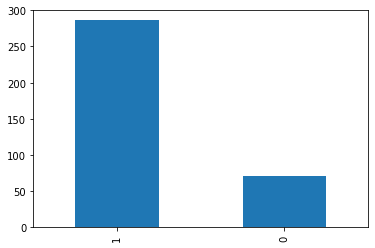

In [11]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [12]:
from itertools import combinations
import random
random.seed(42)


In [13]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=300), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

,TM_A,TM_B
0,60 40 20,OPARUS
1,Xtreme Makeup,EDOMIGE
2,SEARCH SAVVY PR,ESSENTRA
3,The University of Law,Jaded
4,Shortlyster,CONNECT.COM
...,...,...
295,Dylan,Zlide
296,House of Silk,HiGain
297,MOSCANY,BIOBOOSTER
298,Next Deal Shop,PAPA


In [14]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:1


In [15]:
nonmatch_cases.sample(20)

,TM_A,TM_B
165,FINASTRA,Verve Design
187,WELLBOX,RED BULL BBQ GRILLS
289,AMMA,EASYSAIL
150,No More Tangles,TOMMY HERITAGE
197,Horse of London,GOGO
218,Alair,Panda
185,BLUE.COM,Dank Vapes
262,Dr. Wolff,Illumina
56,Eden Pure,VESPER
282,Thirty forty fifty,BLEPHACARE


In [16]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

class_balanced

# class_balanced[class_balanced['TM_B'].str.len()!=0]


,TM_A,TM_B,target
0,Simoniz,Permanize,1
1,Magnavoc,Multivox,1
2,Zirco,Cozirc,1
3,Platinum Puff,Platinum Plus,1
4,Maternity Yours,Your Maternity Shop,1
...,...,...,...
352,Lilton,Wilton,0
353,Nutricia,Nutritea,0
354,Glenreidh,An Reidhe,0
355,No Gunk No Junk,No Gunk Just Funk,0


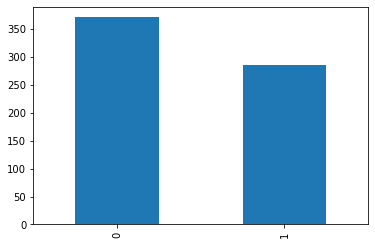

In [17]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [18]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

<ipython-input-18-213a59b7ad7e>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,metaphone,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
169,Harry’s Bar,Harry Gordon’s Bar,1,harrysbar,harrygordonsbar,67,75,75,0.171429,0,...,1.000000,0.633333,0.222222,0.650000,0.792593,0.510739,0.400000,0.978922,0.476471,0.600000
202,DUNSTON,Willow Tree Gin,0,dunston,willowtreegin,29,20,20,0.314286,0,...,0.000000,0.384615,0.000000,0.388462,0.313187,0.028108,0.076923,0.734804,0.263492,0.482630
109,ELYSIUM,JOBZGENIE,0,elysium,jobzgenie,29,25,25,0.257143,0,...,0.000000,0.222222,0.000000,0.211111,0.417989,0.063889,0.111111,0.552941,0.255319,0.600358
185,BLUE.COM,Dank Vapes,0,bluecom,dankvapes,14,12,12,0.257143,0,...,0.000000,0.111111,0.000000,0.272222,0.000000,0.018434,0.111111,0.796569,0.225490,0.623656
17,INVESTED. TOGETHER.,PIC NIC,0,investedtogether,picnic,0,18,18,0.457143,0,...,0.000000,0.156250,0.000000,0.362500,0.486111,0.000000,0.125000,0.488235,0.236364,0.339718
339,LA MERCI,MERCI,0,lamerci,merci,100,83,83,0.057143,0,...,0.833333,0.714286,0.500000,0.714286,0.904762,0.690476,0.714286,0.803922,0.729730,0.714286
167,LOCO,LOKA,1,loco,loka,50,50,50,0.057143,1,...,0.833333,0.750000,0.285714,0.750000,0.666667,0.500000,0.500000,0.998039,0.750000,0.943548
49,PRO GAINS,HAMILTON,0,progains,hamilton,38,38,38,0.228571,0,...,0.000000,0.187500,0.000000,0.100000,0.583333,0.145960,0.375000,0.655882,0.297727,0.618952
294,INTERCONTEC INFINITE CONNECTIONS\t,INTERCONNECT SOLUTIONS,0,intercontecinfiniteconnections,interconnectsolutions,71,67,67,0.371429,0,...,1.000000,0.616667,0.311111,0.671667,0.763492,0.517038,0.433333,1.000000,0.550617,0.682796
34,Camel activ,Camel Capa,1,camelactiv,camelcapa,67,63,63,0.114286,0,...,0.666667,0.600000,0.233333,0.680000,0.778307,0.600000,0.600000,0.992647,0.672222,0.780645


#### Export clean data to csv

In [19]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [20]:
y = df.target
X = df.drop(columns = 'target')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [ ]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [24]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

,target,partial,tkn_sort,tkn_set,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,1,57,50,50,0.142857,0,0,0,0,0.485480,...,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,1,38,38,38,0.142857,0,0,0,0,0.050000,...,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,1,89,73,73,0.085714,0,0,0,0,0.821263,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,1,83,83,83,0.085714,0,0,0,1,0.884677,...,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,1,74,65,65,0.257143,0,0,0,0,0.951613,...,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0,83,83,83,0.028571,0,0,0,0,0.897436,...,0.833333,0.833333,0.500000,0.833333,0.822222,0.833333,0.833333,0.866667,0.823529,0.943548
353,0,75,75,75,0.057143,0,0,0,1,0.804167,...,0.833333,0.812500,0.565217,0.787500,0.833333,0.750000,0.750000,0.997549,0.937500,0.973790
354,0,80,71,71,0.114286,0,0,0,0,0.800858,...,0.666667,0.666667,0.310345,0.666667,0.741402,0.588889,0.666667,0.784804,0.705882,0.655914
355,0,67,77,77,0.142857,0,0,0,1,0.852383,...,0.833333,0.678571,0.469388,0.700000,0.815873,0.637363,0.714286,0.995588,0.713415,0.808756


In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5, min_samples_leaf=10, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

In [26]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [27]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.35112025409619513,
 0.6702700201918589,
 0.16323738118861,
 0.6330568226983103,
 0.16323738118861,
 0.626720196506135,
 0.7053552309896098,
 0.16323738118861,
 0.6874011722938973,
 0.7025578206353692,
 0.2557027149778569,
 0.6737335658025978,
 0.671052669720941,
 0.16323738118861,
 0.16659745609034987,
 0.16323738118861,
 0.16323738118861,
 0.18526761802516206,
 0.6995389474924879,
 0.6679158647370822,
 0.5888994626719004,
 0.6593520385548661,
 0.7535091640685181,
 0.16304445525505942,
 0.16323738118861,
 0.2549397396300578,
 0.6651310331291863,
 0.19509117516559993,
 0.16323738118861,
 0.16390736867760353,
 0.7447419348282912,
 0.7222551924488118,
 0.16323738118861,
 0.5622943080171677,
 0.7391024446409264,
 0.5710079684685267,
 0.6234979616189069,
 0.5900421681347799,
 0.7447419348282912,
 0.6591115425354162,
 0.33992711741647585,
 0.16591865470841616,
 0.7430660226586402,
 0.16591865470841616,
 0.70214526981173,
 0.16323738118861,
 0.6866767032568911,
 0.7430660226586402,
 0.6577

## K-fold cross validation

In [28]:
from sklearn.model_selection import StratifiedKFold

In [29]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

#     oof_pred['siamese_sim'] = base_model_2(X_train[['name_a', 'name_b']],
#                                       y_train,
#                                       X_test[['name_a', 'name_b']])
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [30]:
meta_training.sample(20)


,TM_A,TM_B,predict_proba,target
57,upgooats,hardcore,0.169340,0
128,dialux,dial,0.677585,1
235,imperialreserva,imperial,0.732702,1
71,edenpure,edenaesthetics,0.645059,1
293,eezeevet,easipetcareltd,0.240520,0
69,naturefarmfood,canvaslifestyle,0.169525,0
34,camelactiv,camelcapa,0.701682,1
46,swisse,swisslifeforever,0.681933,1
141,bodrum,didim,0.201698,1
95,naturefarmfood,farmnature,0.637390,1


### Meta-Model: Logistic Regression

In [31]:
df=featurize(meta_training)

In [32]:
df.sample(20)

,a,b,predict_proba,target,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
243,lafrancaiseinvestingtogether,thew,0.264621,0,lafrancaiseinvestingtogether,thew,75,19,19,0.714286,...,0.000000,0.142857,0.000000,0.232143,0.428571,0.000000,0.000000,0.626471,0.111842,0.130184
222,londonhairlab,gameofstones,0.168905,0,londonhairlab,gameofstones,25,24,24,0.342857,...,0.000000,0.269231,0.000000,0.146154,0.493590,0.110122,0.153846,0.765686,0.254930,0.720844
125,blephaclean,willowtreegin,0.185320,0,blephaclean,willowtreegin,36,33,33,0.285714,...,0.333333,0.423077,0.000000,0.392308,0.557110,0.224359,0.307692,0.832843,0.406349,0.648883
140,ofo,ovo,0.674461,1,ofo,ovo,67,67,67,0.028571,...,0.833333,0.833333,0.384615,0.966667,0.777778,0.666667,0.666667,0.999020,0.769231,0.989247
7,woodystout,woodybrownale,0.603822,1,woodystout,woodybrownale,60,52,52,0.200000,...,0.500000,0.538462,0.105263,0.550000,0.687179,0.441142,0.461538,0.835294,0.485714,0.727047
279,micron,therealpetfoodcompany,0.167358,0,micron,therealpetfoodcompany,50,22,22,0.514286,...,0.000000,0.238095,0.000000,0.371429,0.476190,0.000000,0.047619,0.680392,0.182883,0.269585
31,theuniversityoflaw,ulaw,0.334822,1,theuniversityoflaw,ulaw,75,36,36,0.400000,...,0.000000,0.277778,0.000000,0.383333,0.435185,0.000000,0.055556,0.563235,0.150000,0.222222
276,vype,veype,0.692897,1,vype,veype,75,89,89,0.028571,...,1.000000,0.800000,0.866667,0.900000,0.933333,0.800000,0.800000,0.998039,0.934783,0.800000
85,grey,maternityyours,0.166972,0,grey,maternityyours,25,22,22,0.342857,...,0.000000,0.321429,0.000000,0.357143,0.543651,0.000000,0.071429,0.710294,0.150000,0.268433
281,eris,gameofstones,0.169777,0,eris,gameofstones,50,25,25,0.285714,...,0.000000,0.250000,0.000000,0.295833,0.555556,0.000000,0.166667,0.649020,0.167187,0.327957


### Evaluate Gradient Boosting Classifier

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[32  5]
 [ 4 24]]
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        37
           1       0.83      0.86      0.84        28

    accuracy                           0.86        65
   macro avg       0.86      0.86      0.86        65
weighted avg       0.86      0.86      0.86        65



In [34]:
# df_confusion.to_csv('TM_GBC_Confusion_matris.csv')

In [35]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.926')

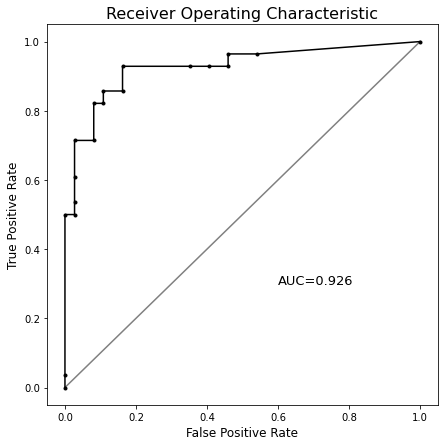

In [36]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

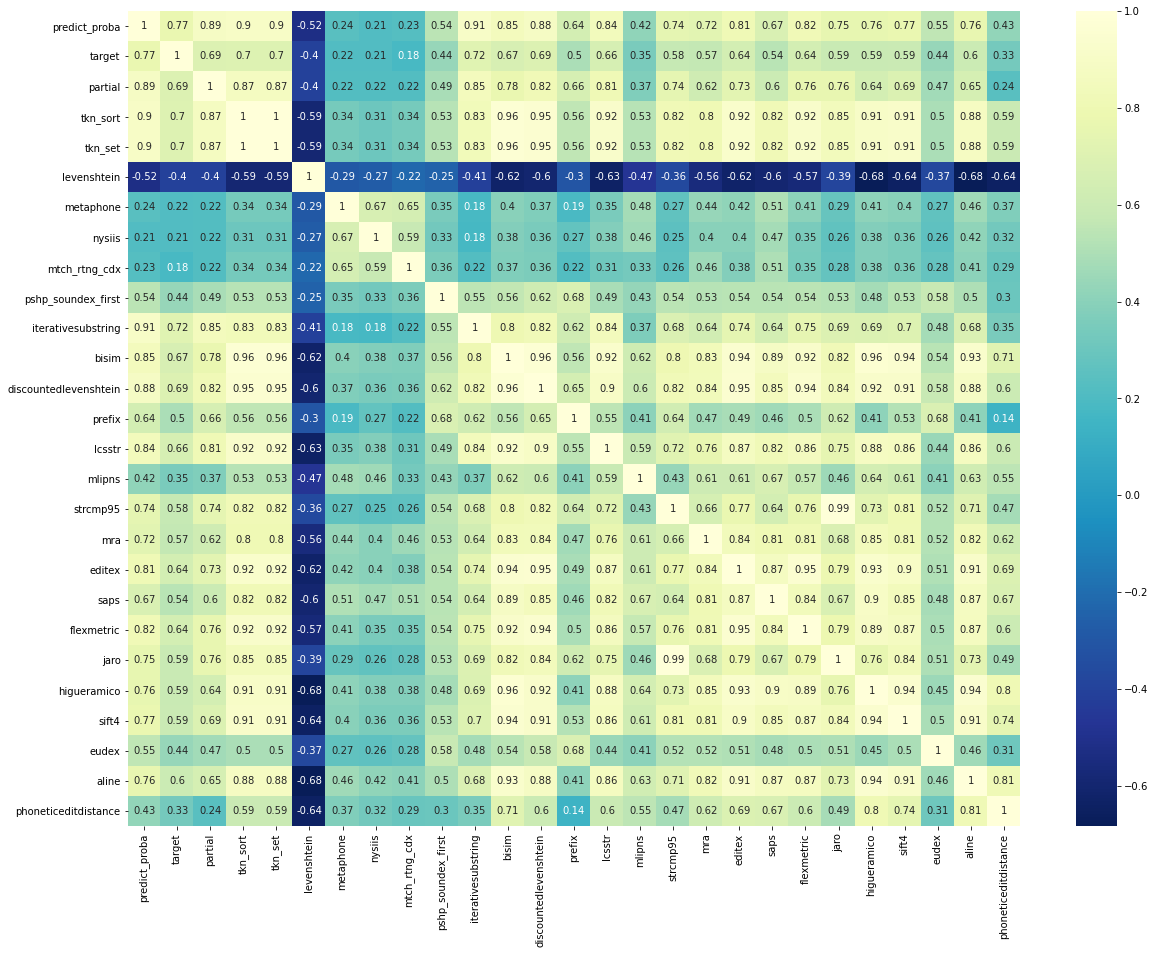

In [37]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# XGboost

In [53]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


X

,a,b,TM_A,TM_B,partial,tkn_sort,tkn_set,levenshtein,metaphone,nysiis,...,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
2,zirco,cozirc,zirco,cozirc,89,73,73,0.085714,0,0,...,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
8,frickinchicken,flipnchicken,frickinchicken,flipnchicken,75,77,77,0.114286,0,0,...,0.666667,0.785714,0.500000,0.757143,0.782540,0.708791,0.642857,0.919118,0.758537,0.835253
12,kresco,cresco,kresco,cresco,83,83,83,0.028571,1,1,...,0.833333,0.916667,0.619048,0.983333,0.888889,0.833333,0.833333,0.874510,0.911765,0.994624
14,starbucks,sambucks,starbucks,sambucks,75,82,82,0.057143,0,0,...,0.666667,0.777778,0.676471,0.844444,0.884259,0.777778,0.777778,0.798039,0.709091,0.867384
45,zlide,logicslide,zlide,logicslide,80,53,53,0.171429,0,0,...,0.000000,0.450000,0.085714,0.550000,0.533333,0.254365,0.200000,0.762255,0.462963,0.496774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,richmond,richman,richmond,richman,86,80,80,0.057143,0,0,...,0.833333,0.812500,0.607143,0.837500,0.869048,0.750000,0.750000,0.900980,0.812500,0.850806
328,mobe,mobicard,mobe,mobicard,75,50,50,0.142857,0,0,...,0.000000,0.437500,0.142857,0.543750,0.708333,0.240476,0.375000,0.947059,0.420455,0.495968
333,cat,catcleanairtechnology,cat,catcleanairtechnology,100,25,25,0.514286,0,0,...,0.000000,0.214286,0.000000,0.311905,0.714286,0.000000,0.142857,0.909804,0.162162,0.142857
336,astonmartin,astonhill,astonmartin,astonhill,56,60,60,0.171429,0,0,...,0.500000,0.590909,0.225806,0.604545,0.737374,0.475758,0.545455,0.994608,0.473770,0.762463


In [54]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

In [55]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

In [56]:
xgbmodel = xgb.train(param, D_train, steps)

In [57]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.8740510697032436
Recall = 0.8763888888888889
Accuracy = 0.8712121212121212


In [58]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [59]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

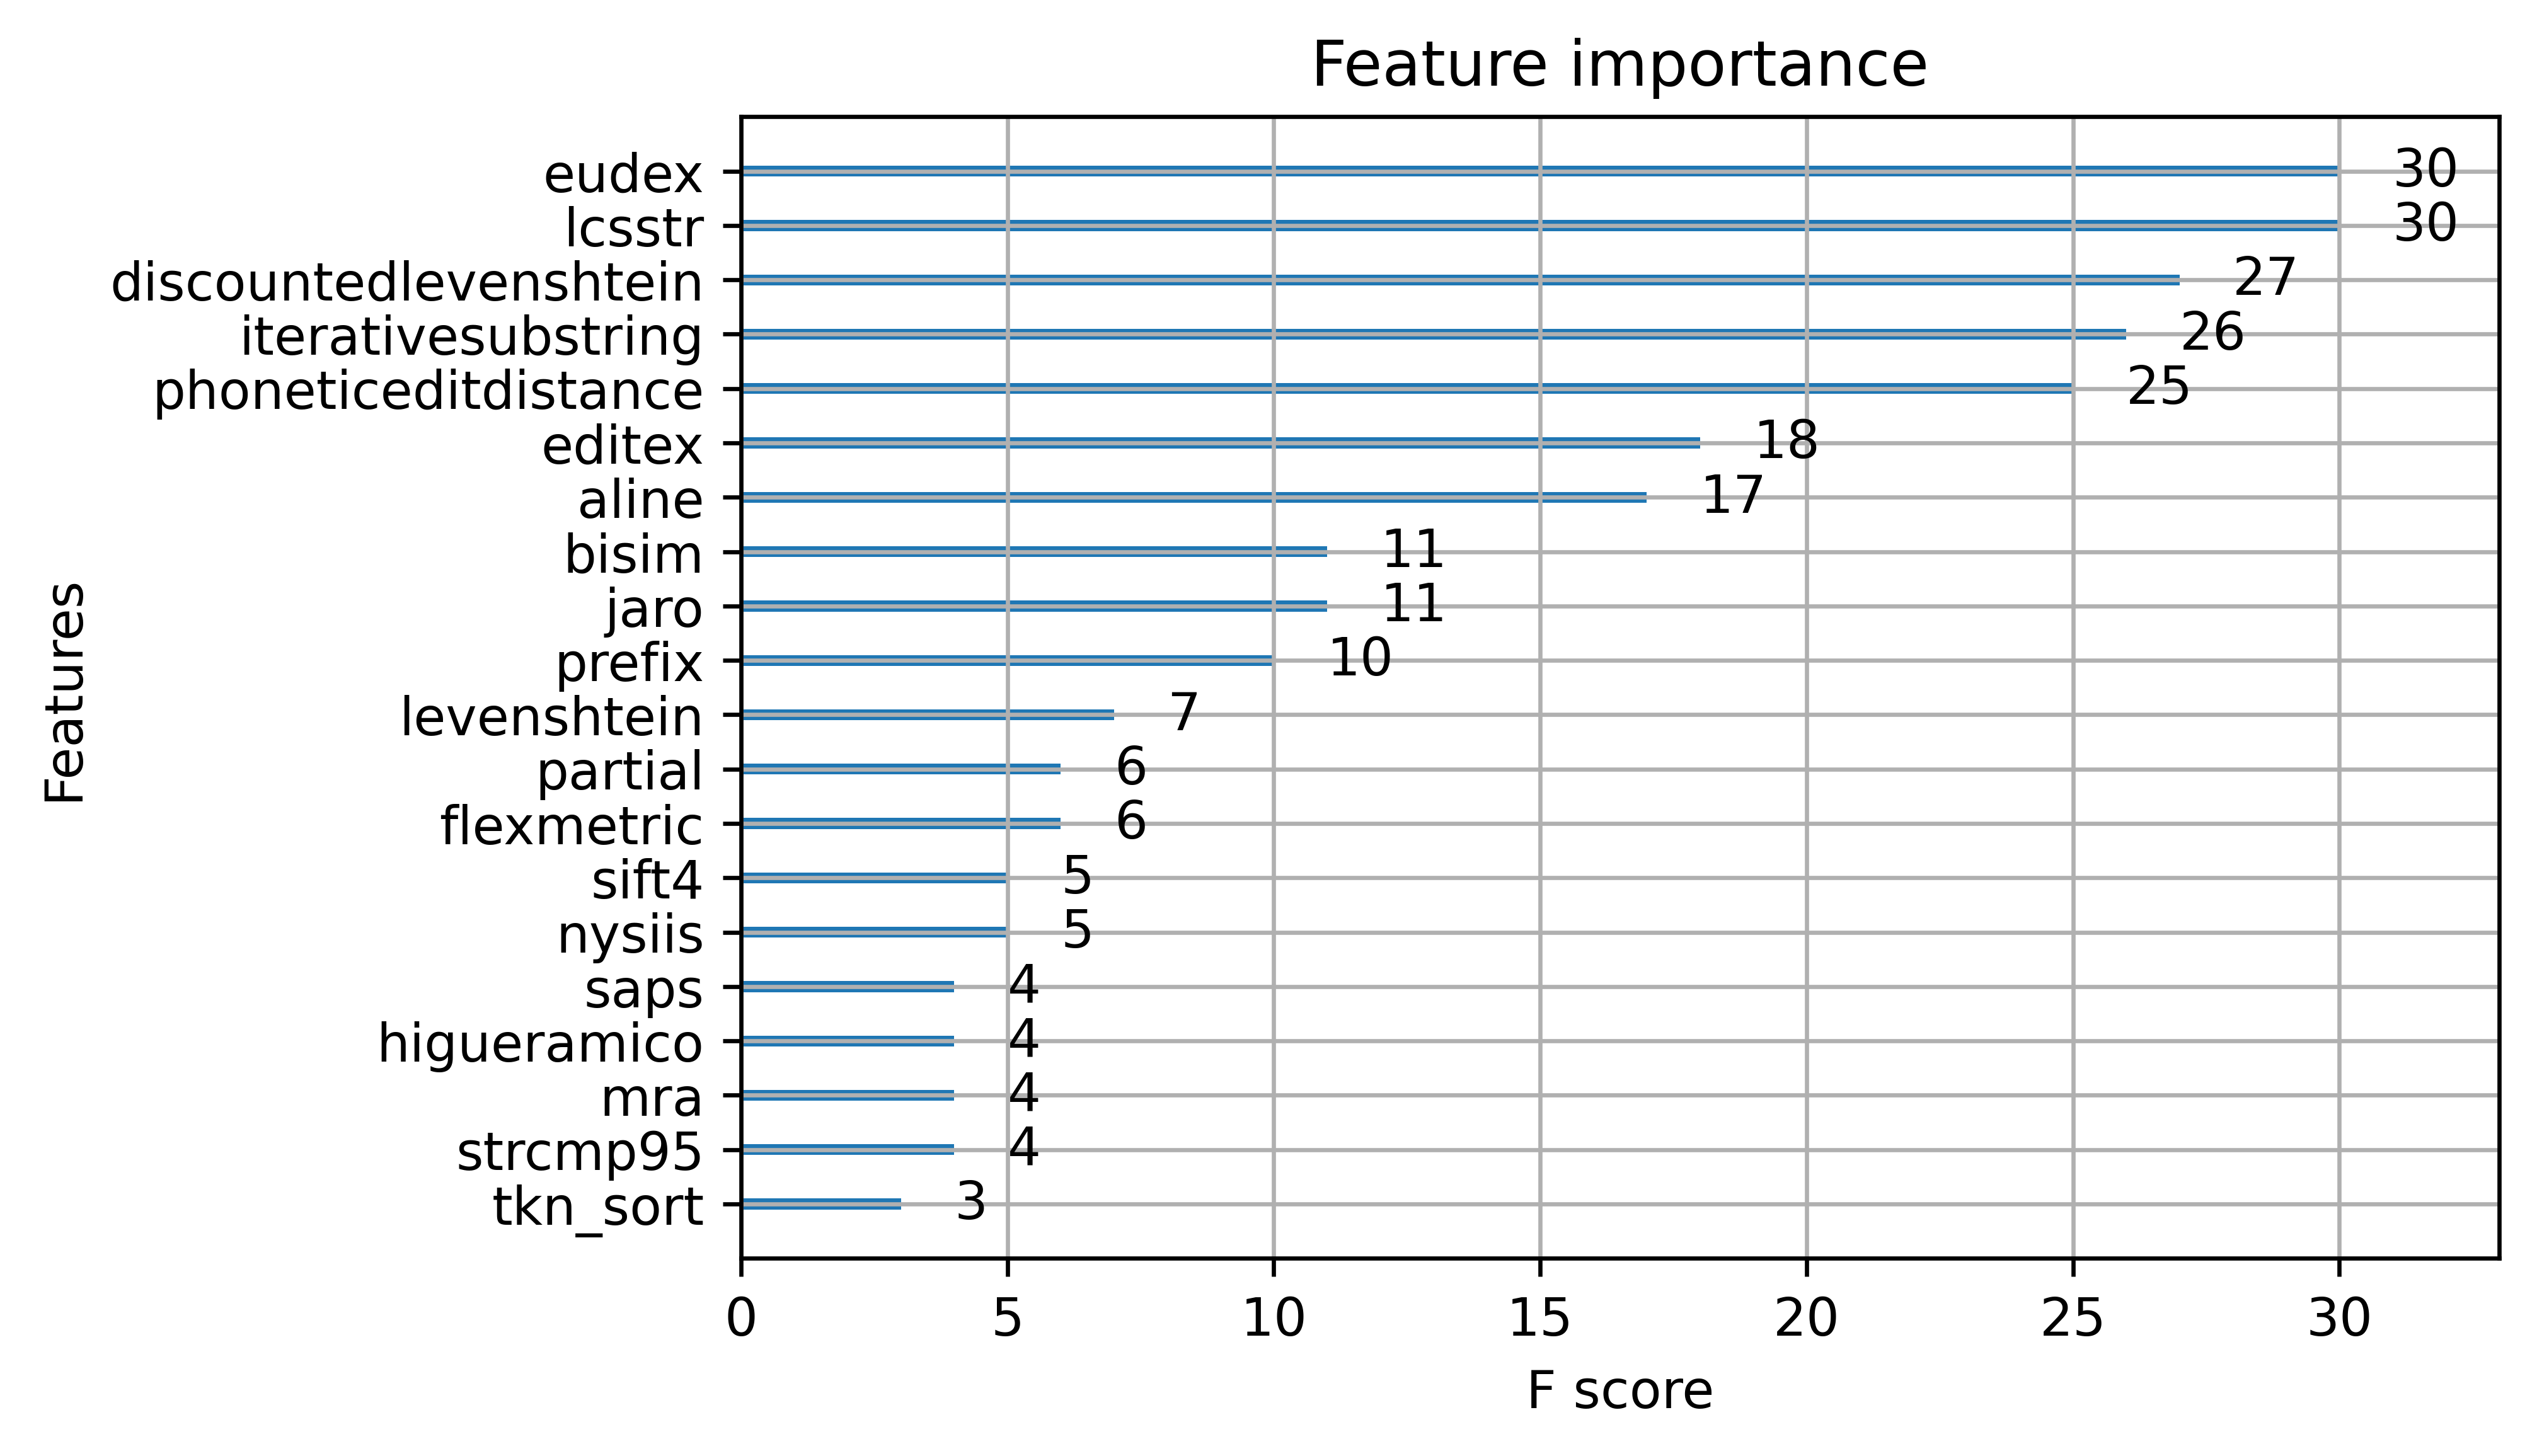

In [60]:
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
pyplot.show()

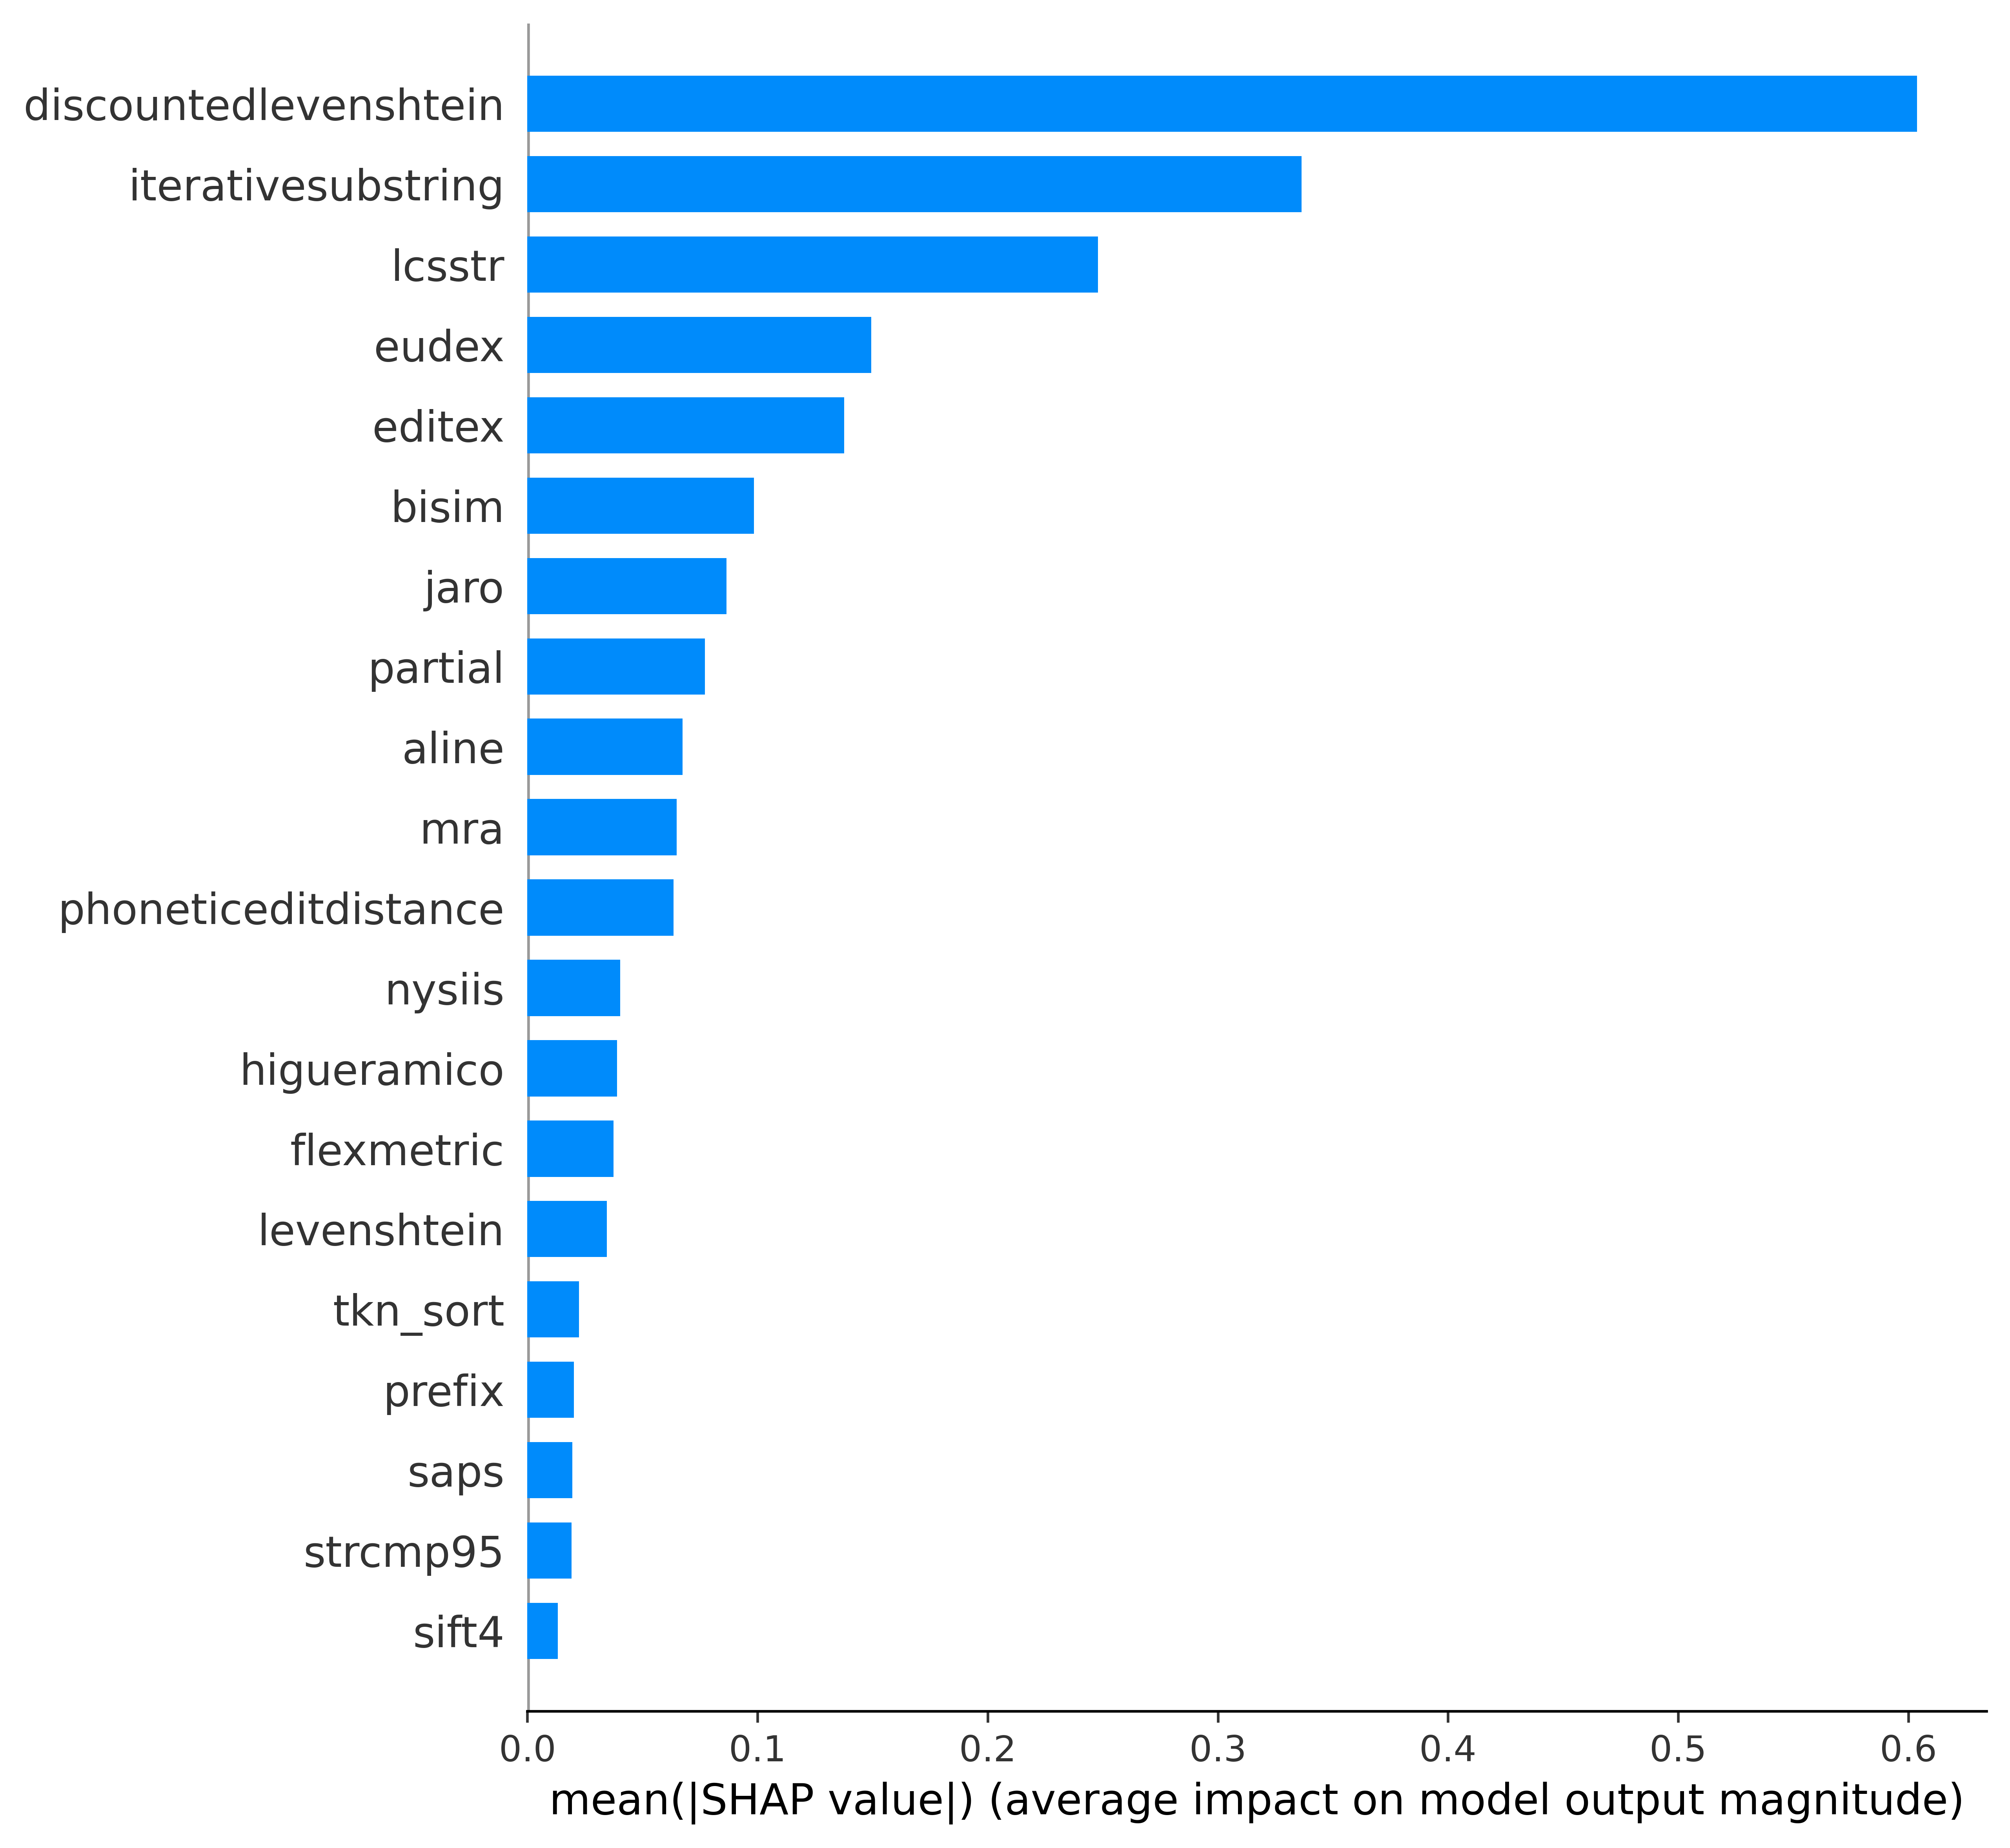

In [61]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar")

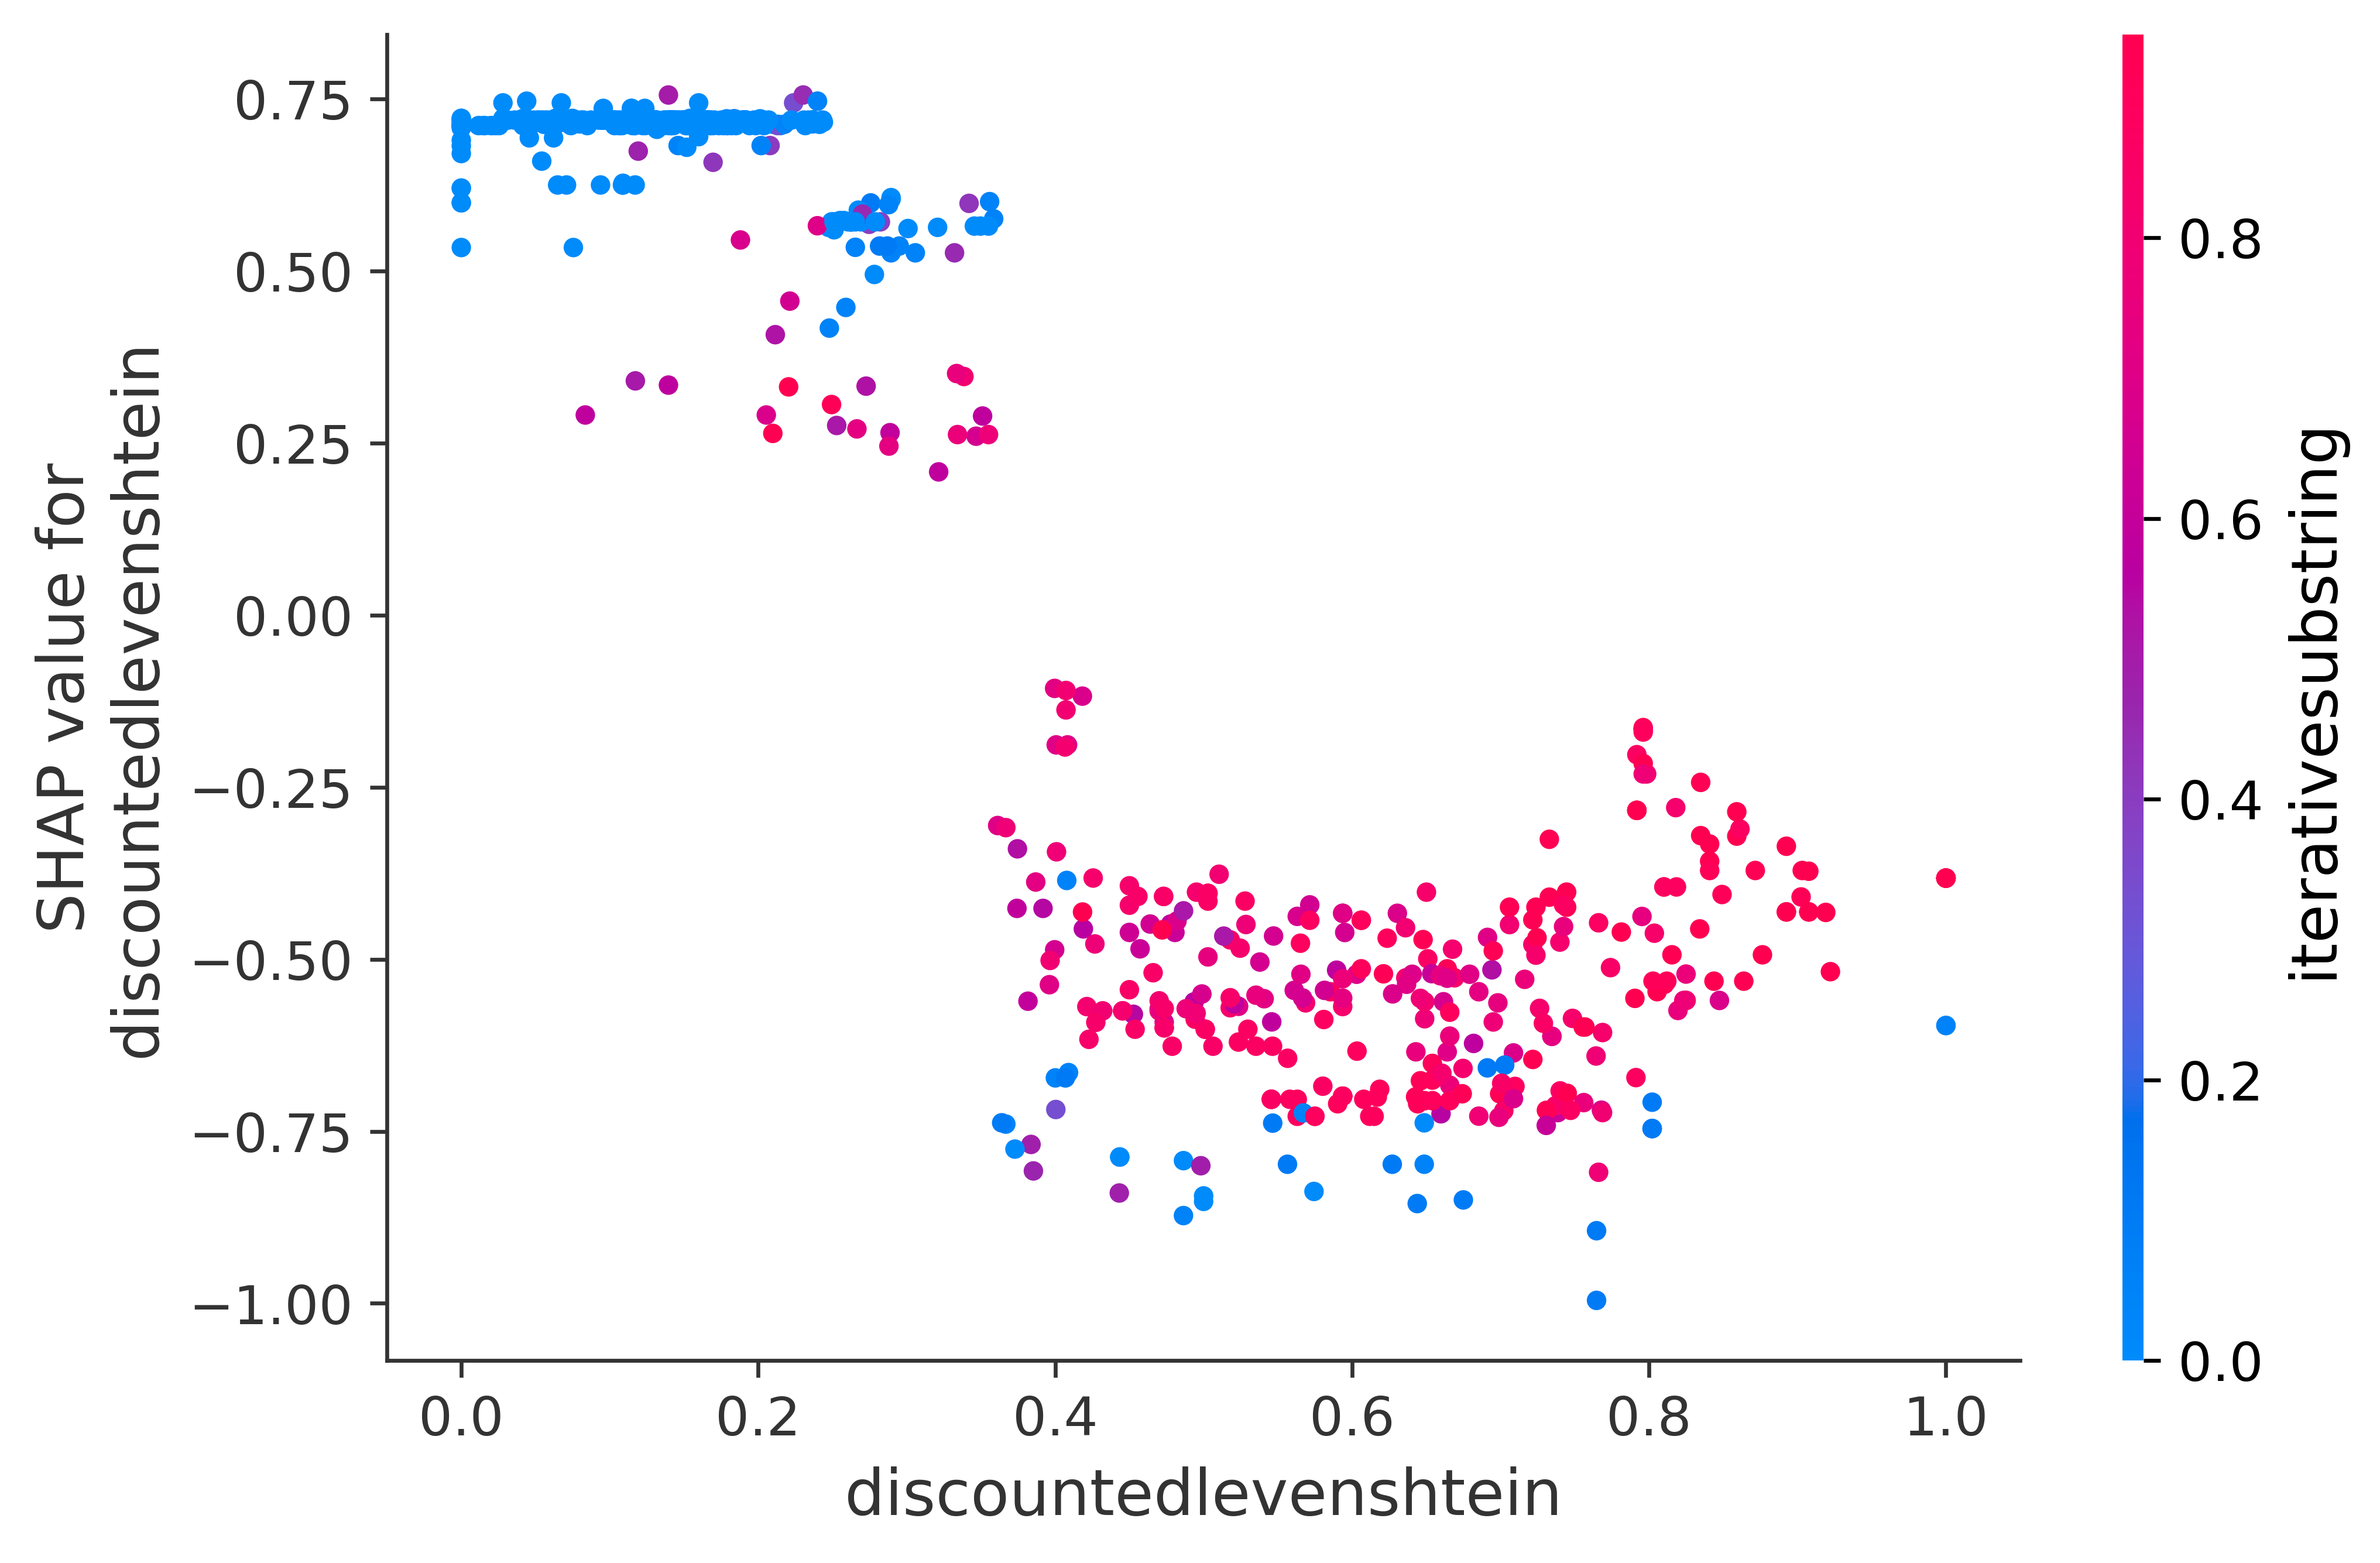

In [62]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


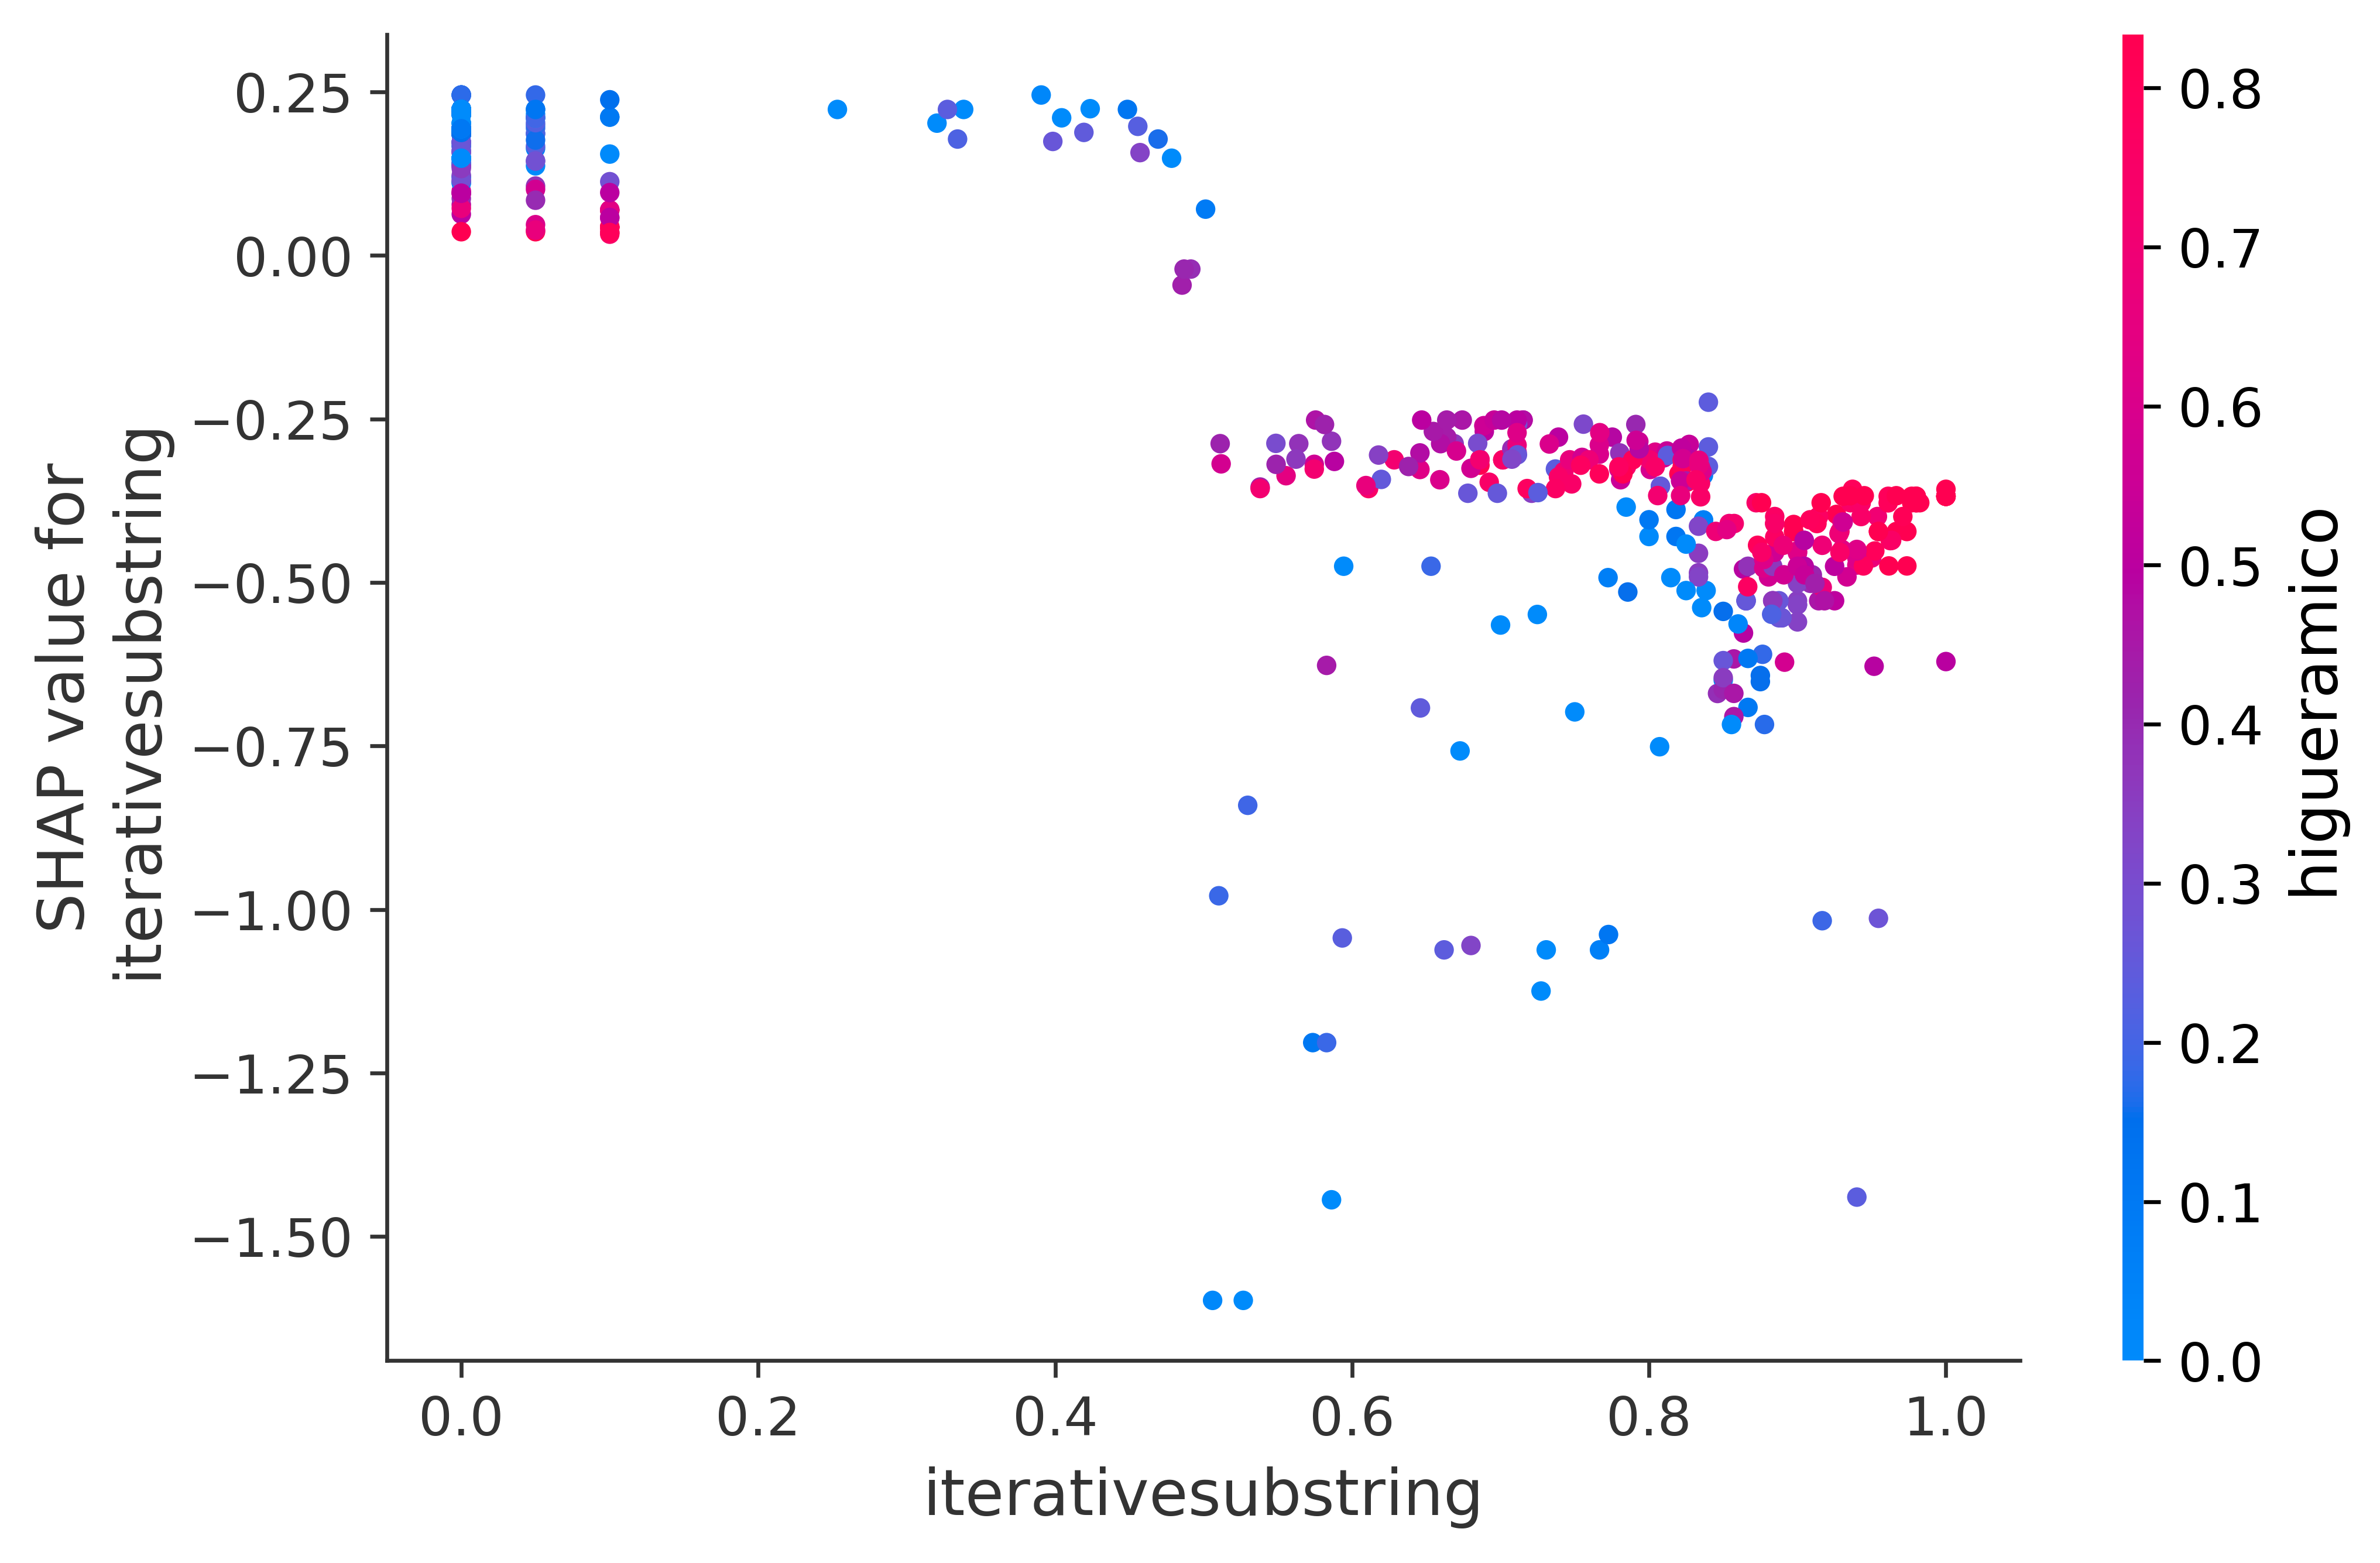

In [48]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


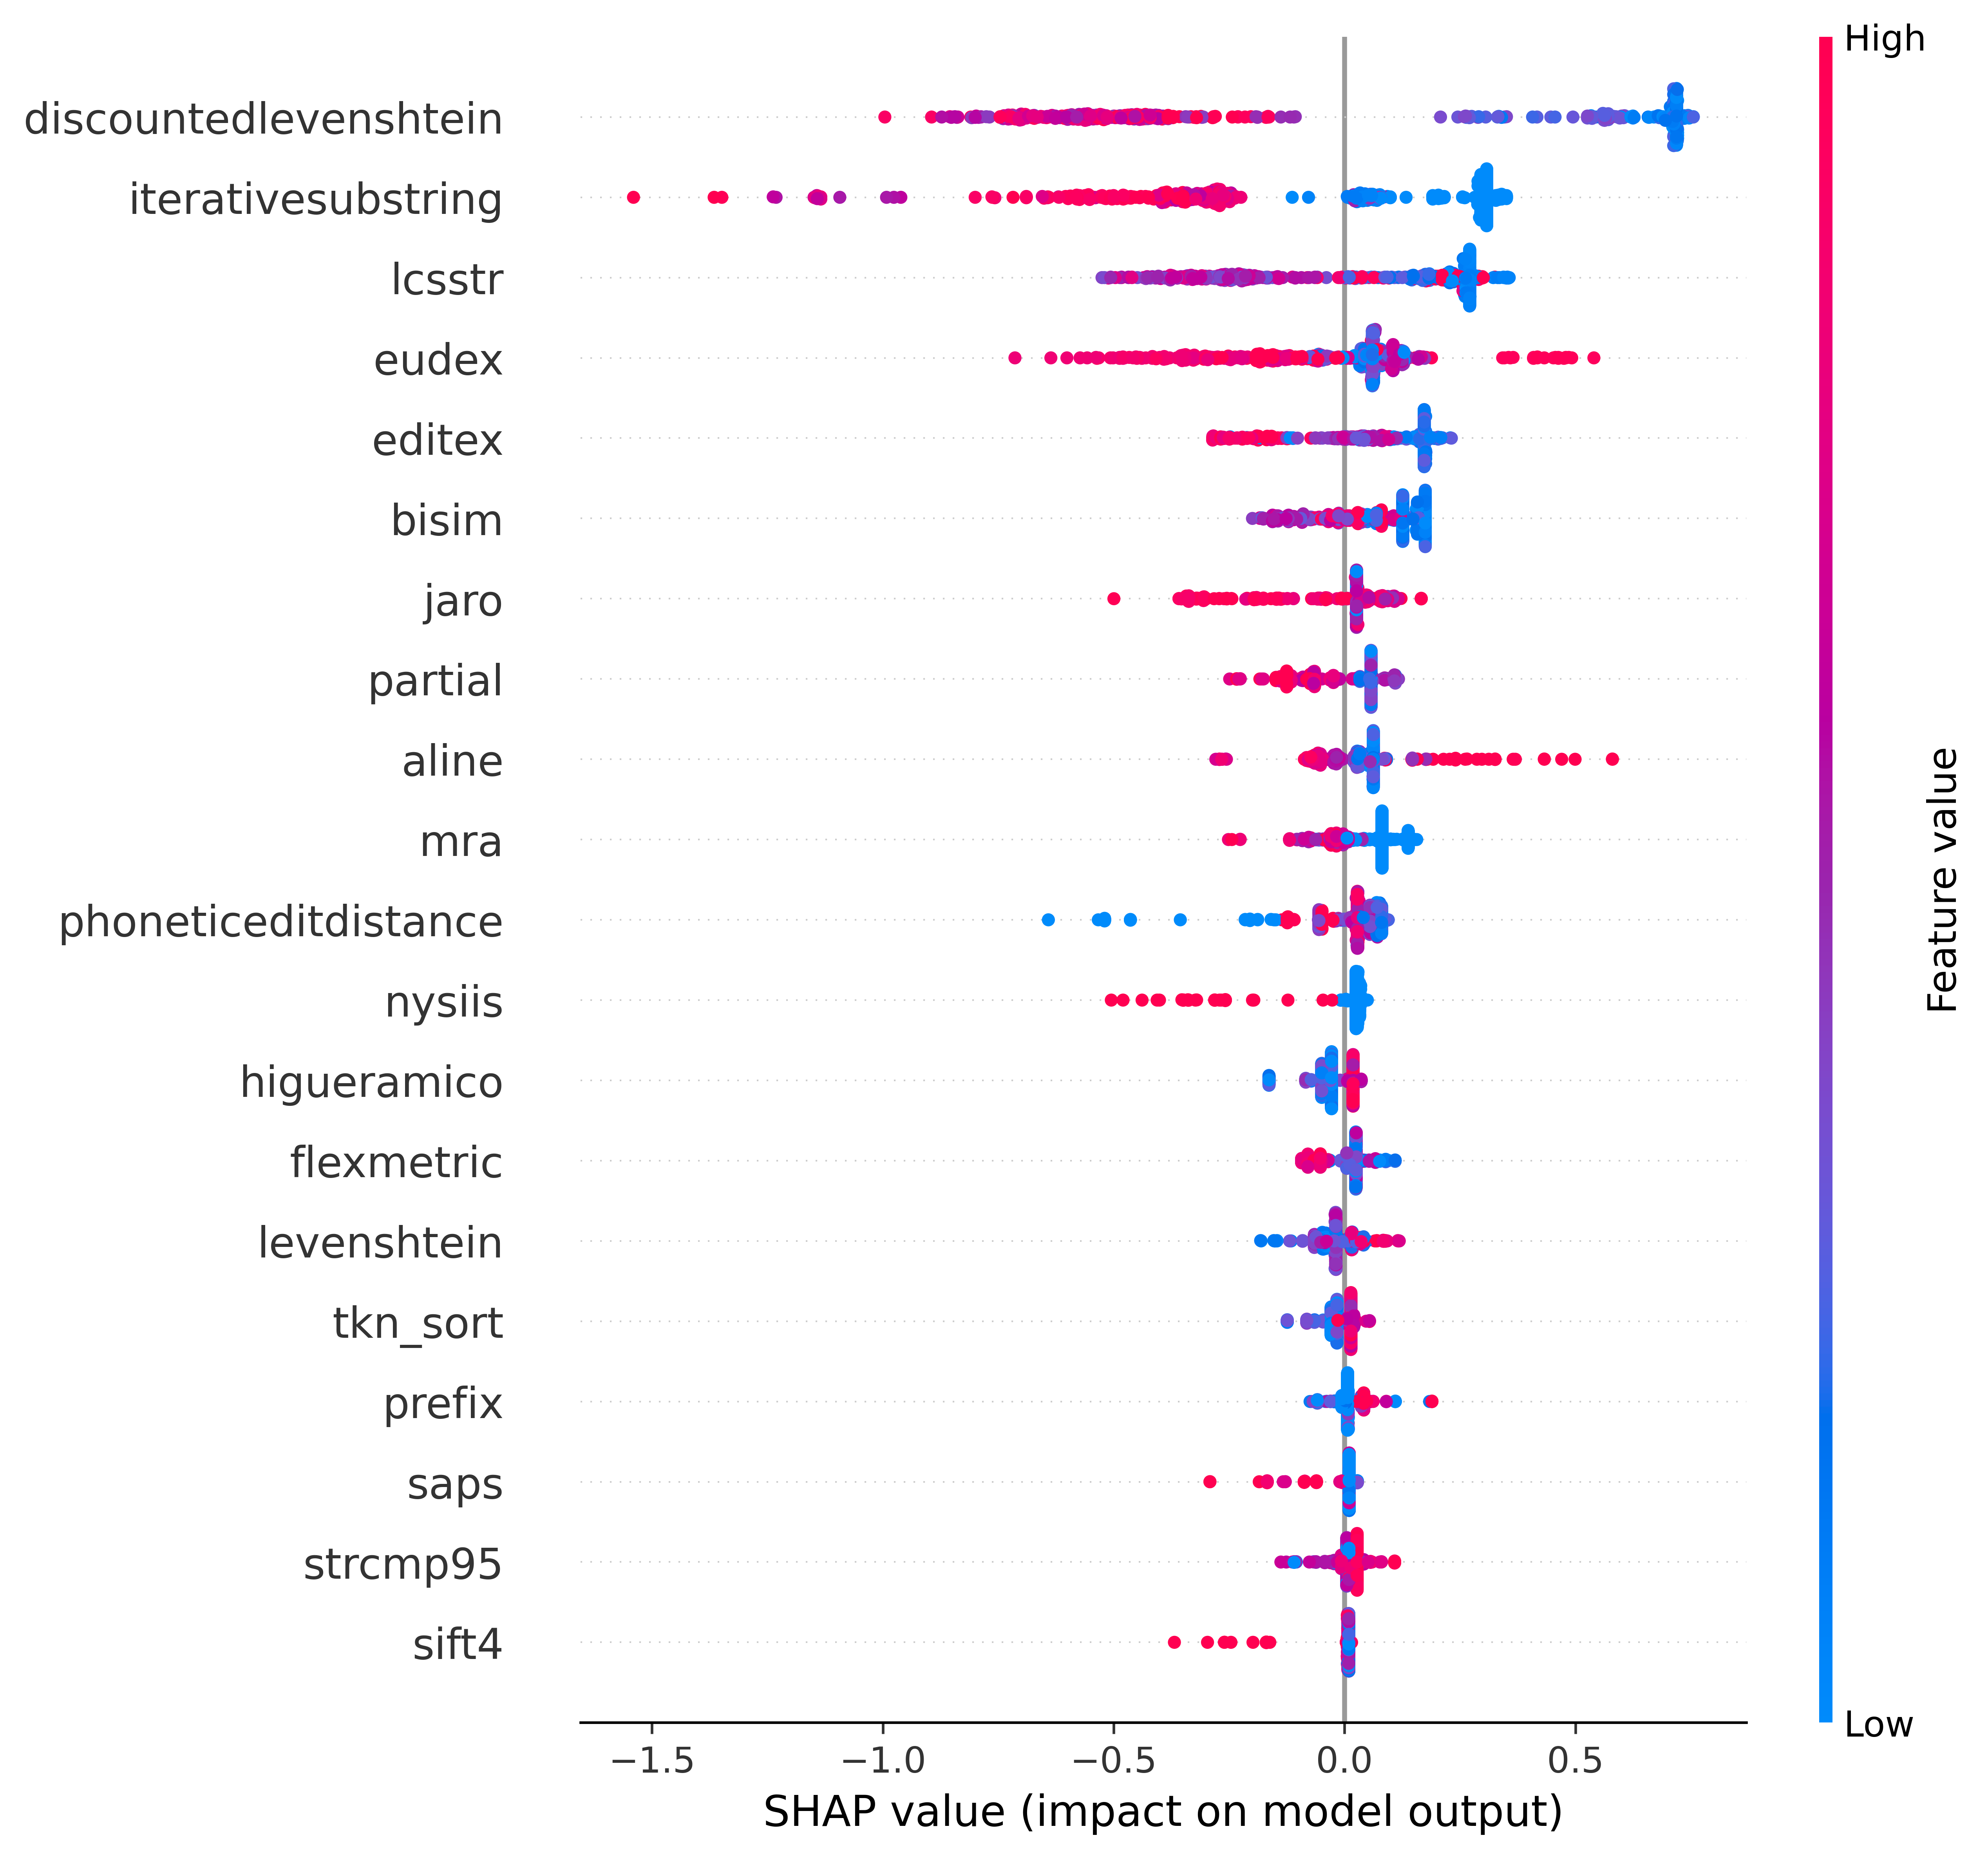

In [63]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['predict_proba', 'tkn_set', 'iterativesubstring', 'strcmp95']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')

### TPOT AutoML Regression

In [ ]:
from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
        scoring = 'f1', 
        generations=100,
        verbosity=2,
        n_jobs=-1   # Utilizes all available CPU cores
        ) 
pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

exported_pipeline = make_pipeline(